In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wrw_z_58
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wrw_z_58
  Resolved https://github.com/facebookresearch/detectron2.git to commit 38af375052d3ae7331141bc1a22cfa2713b02987
  Preparing metadata (setup.py) ... done


In [ ]:
# clone and install Mask2Former
!git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
!pip install -U opencv-python
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

Cloning into 'Mask2Former'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 297 (delta 126), reused 293 (delta 126), pack-reused 4
Receiving objects: 100% (297/297), 412.62 KiB | 6.88 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/Mask2Former/Mask2Former
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-1nq2e5h0
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-1nq2e5h0
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent

In [ ]:
!pip install faiss-gpu

Restart runtime here for proper installation

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import seaborn as sb
from matplotlib import cm

import cv2
import faiss
from google.colab.patches import cv2_imshow
from skimage.measure import block_reduce

In [ ]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.13 ; cuda:  cu116


In [ ]:
%cd /content/Mask2Former
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()
setup_logger(name="mask2former")

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former import add_maskformer2_config

/content/Mask2Former


In [ ]:
class L2Norm(nn.Module):
  def __init__(self, dim=1):
    super().__init__()
    self.dim = dim

  def forward(self, input):
    return F.normalize(input, p=2, dim=self.dim)

In [ ]:
encoder_dim = 512
encoder = models.vgg16(weights=models.vgg.VGG16_Weights.DEFAULT)
encoder.cuda()
# capture only feature part and remove last relu and maxpool
layers = list(encoder.features.children())[:-2]
layers.append(L2Norm())
encoder = nn.Sequential(*layers)

In [ ]:
summary(encoder, (3,640,480))

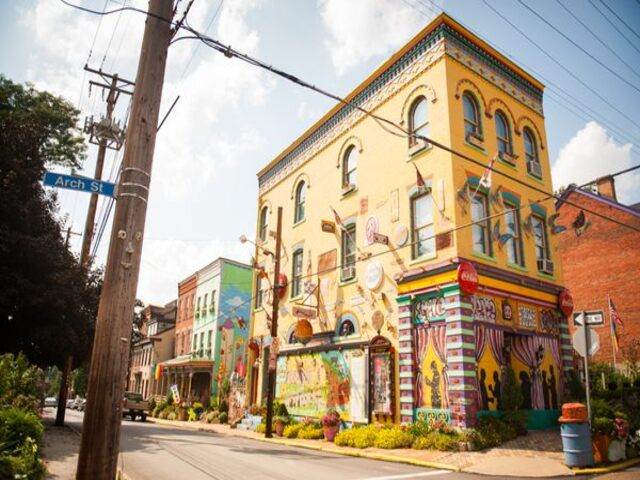

In [ ]:
imgTest = cv2.imread("/content/testImage2.jpg")
cv2_imshow(imgTest)

In [ ]:

# Transform the image as required by the VGG-16 for input

transform_pipeline = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

img = Image.fromarray(imgTest)
img = transform_pipeline(img)
img = img.unsqueeze(0)  
img = Variable(img)
img = img.cuda()
encoder.eval()
with torch.no_grad():
  output = encoder(img)
output.shape

torch.Size([1, 512, 30, 40])

In [ ]:
inputs_in_3d = torch.transpose(torch.squeeze(output), 0, 2)
print(inputs_in_3d.shape)
inputs = inputs_in_3d.reshape([1200, 512]).cpu()

torch.Size([40, 30, 512])


In [ ]:
km = faiss.Kmeans(512, 256, niter = 16, verbose = True)
km.train(inputs.numpy())

55.88410568237305

Identifying the different clusters in the image overall

In [ ]:
index = faiss.IndexFlatL2(512)
index.add(km.centroids)
distances, clusterAssignment = index.search(inputs.numpy(), 1)
clusterAssignment.ravel()

array([ 52,  52, 254, ...,  96,  43, 106])

In [ ]:
noOfInformative = 1
noOfShadow = 4

In [ ]:
# Hard coded the labels to be identified as shadow areas
# These include persons, animals, vehicles, sky and trees
shadow_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 116, 119] 

In [ ]:
#Declare the mask2former model
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("configs/coco/panoptic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_100ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_f07440.pkl'
# cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
predictor = DefaultPredictor(cfg)

[02/01 01:56:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_f07440.pkl ...
WARNING [02/01 01:56:15 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [ ]:
inds = clusterAssignment.ravel().argsort()
sortedInputs = inputs.numpy()[inds]
splitClusters = np.split(sortedInputs, np.where(np.diff(np.sort(clusterAssignment.ravel())))[0]+1)

In [ ]:
outputs = predictor(imgTest)
labels = np.array(outputs["sem_seg"].argmax(0).to("cpu"))
labels = block_reduce(labels, block_size=(16,16),func=np.max)

In [ ]:
ogIndex = [x for x in range(40 * 30)]
sortedIndex = np.array(ogIndex)[inds]

In [ ]:
labels = labels.reshape(1200, 1)
sortedLabels = labels[inds]
splitLabels = np.split(sortedLabels, np.where(np.diff(np.sort(clusterAssignment.ravel())))[0]+1)

In [ ]:
b = 10

def customSoftmax(x, shadow, informative):
  informativeScore = np.sum(np.exp(-1 * b * (x - informative) ** 2))
  shadowScore = np.sum(np.exp(-1 * b * (x - shadow) ** 2))
  return informativeScore / (informativeScore + shadowScore)

In [ ]:
weights = []
# Iterate through each of the clusters and their respective labels
for cluster, labels in zip(splitClusters, splitLabels):

  # Collect the informative and shadow centroids in the cluster
  informativeInCluster = []
  shadowInCluster = []
  for element, label in zip(cluster, labels):
    (informativeInCluster, shadowInCluster)[label in shadow_labels].append(element)

  # Adjustments as described above
  if not informativeInCluster:
    informativeInCluster.append(cluster[0])
  if not shadowInCluster:
    shadowInCluster.append(cluster[0])

  # Finding the centroids
  informativeCentroid = np.mean(informativeInCluster, axis = 0)
  shadowCentroids = shadowInCluster
  if len(shadowCentroids) > 4:
    kMeans = faiss.Kmeans(512, 4, niter = 16)
    kMeans.train(np.array(shadowCentroids))
    shadowCentroids = kMeans.centroids
  
  for element in cluster:
    # Append the weight for this particular point
    weights.append(customSoftmax(element, shadowCentroids, informativeCentroid))

In [ ]:
inds = sortedIndex.argsort()
weights = np.array(weights)[inds]
# Reshape the weights to the size of the output
weights = np.array(weights)

In [ ]:
weights = weights.reshape((30,40))

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
sb.heatmap(weights,ax=ax, alpha = 0.7, zorder = 2,  cmap="viridis", cbar = False)
ax.imshow(imgTest, aspect = ax.get_aspect(),
          extent = ax.get_xlim() + ax.get_ylim(),
          zorder = 1)
ax.axis('off')
plt.savefig('heatmap.png', bbox_inches='tight', pad_inches=0)

experimented with different values of b, so far, b = 100 seems to perform the best
256 clusters perform better than 128 when doing k means clustering initially
experimented with different number of shadow and informative centroids

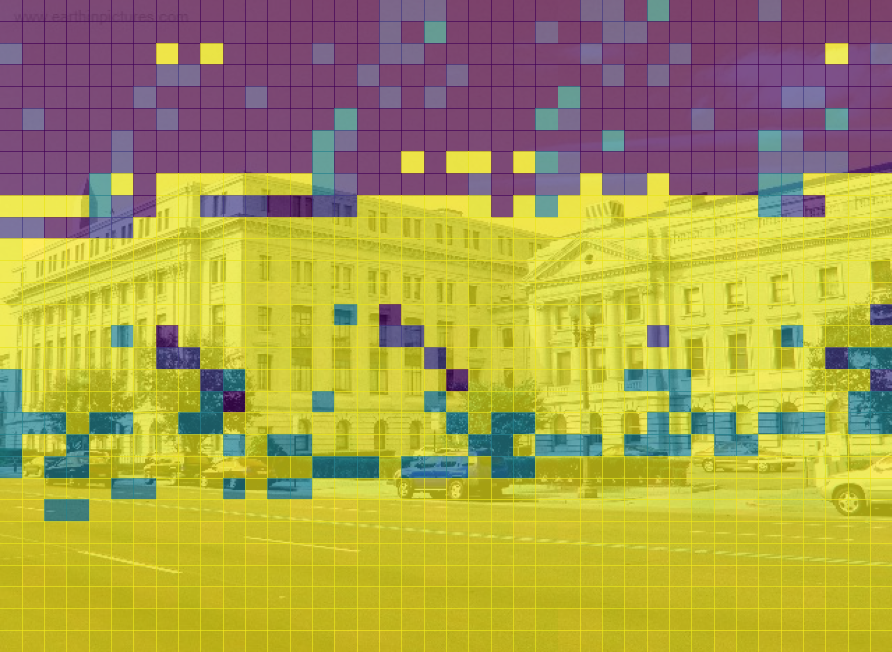

In [ ]:
imgOut = cv2.imread("/content/Mask2Former/heatmap.png")
cv2_imshow(imgOut)

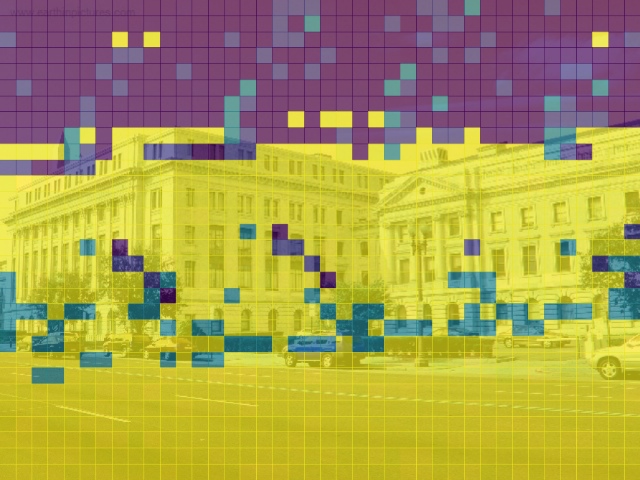

In [ ]:
imgOutResized = cv2.resize(imgOut, (640, 480))
cv2_imshow(imgOutResized)

In [ ]:
cv2.imwrite('heatmap.png', imgOutResized)

True

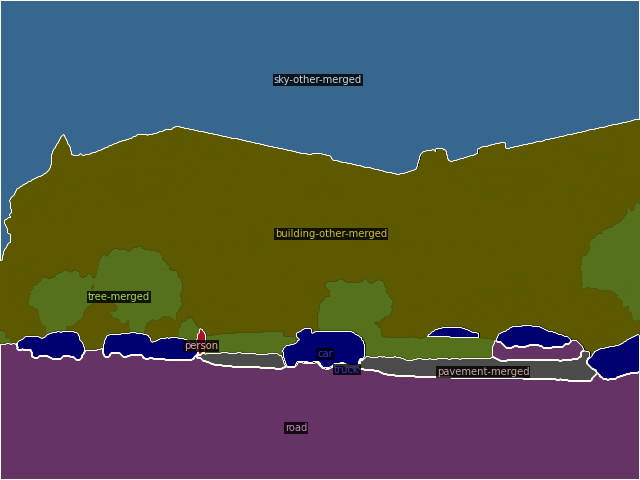

In [ ]:
v = Visualizer([[[0] * 3] * 640] * 480, coco_metadata, instance_mode=ColorMode.IMAGE_BW)
semanticLabels = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
cv2_imshow(semanticLabels[:, :, ::-1])

In [ ]:
testLabels = block_reduce(np.array(outputs["sem_seg"].argmax(0).to("cpu")), block_size=(16,16),func=np.max)

In [ ]:
np.unique(testLabels, return_counts=True)

(array([  2, 100, 116, 119, 123, 129]), array([  9, 282,  45, 347,  37, 480]))